# AR, MA and ARMA Modeling of Time Series

This notebook presents a professional, concept-driven analysis of time series data.
It has been refactored from academic material into a portfolio-ready project,
focused on clarity, statistical reasoning, and reproducibility.


In [17]:
#%pip install darts

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.utils.statistics import plot_acf, plot_pacf
from darts.models import ARIMA
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Base de datos ICAP

El objetivo es estudiar el índice de consumo de agua potable (ICAP) mensual, con datos disponibles desde enero de 1990 hasta mayo de 2024 (412 observaciones). El ICAP es un indicador que refleja la evolución y el comportamiento del consumo de agua potable en los sectores privado y público, tomando como año base 1990 (índice igual a 100). Las variaciones posteriores representan incrementos o decrementos en el consumo mensual respecto al año base.

In [3]:
df = pd.read_table('icap_90_24.txt', header = None, decimal=',')
df.columns = ['icap']
display(df.head(6))
df.info()

,icap
0,102.45
1,96.72
2,106.45
3,103.26
4,100.50
5,96.01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412 entries, 0 to 411
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   icap    412 non-null    float64
dtypes: float64(1)
memory usage: 3.3 KB


In [4]:
# Crea una columna 'fecha' con fechas mensuales desde enero de 1990 hasta abril de 2024.
# freq='MS' indica que las fechas corresponden al **inicio de cada mes** ("Month Start")
df['fecha'] = pd.date_range(start='1990-01', end='2024-04', freq='MS')

# Establece la columna 'fecha' como índice del DataFrame, lo que facilita operaciones temporales
#df.set_index('fecha', inplace=True)

# Asegura que el índice del DataFrame esté en formato datetime para garantizar compatibilidad con funciones de series de tiempo
#df.index = pd.to_datetime(df.index)

# Muestra las primeras 10 filas del DataFrame para inspección
display(df.head(10))

# Convierte la columna 'icap' del DataFrame en un objeto TimeSeries de la librería Darts
# Esto permite aplicar modelos de series temporales más fácilmente
#df_series = TimeSeries.from_series(df['icap'])

# Divide la serie temporal en dos subconjuntos: entrenamiento y validación
# El punto de corte es el 1 de enero de 2023; todo antes es entrenamiento
#df_train, df_val = df_series.split_before(pd.Timestamp('2023-01-01'))

# Extrae los valores del conjunto de entrenamiento como un arreglo NumPy
# squeeze() elimina dimensiones innecesarias del array (por ejemplo, de (n, 1) a (n,))
#train_data_np = df_train.values().squeeze()

# Convierte los datos de entrenamiento a un DataFrame de pandas para procesamiento 
# adicional (por ejemplo, modelado o visualización)
#train_data = pd.DataFrame(train_data_np)


,icap,fecha
0,102.45,1990-01-01
1,96.72,1990-02-01
2,106.45,1990-03-01
3,103.26,1990-04-01
4,100.50,1990-05-01
5,96.01,1990-06-01
6,90.98,1990-07-01
7,98.82,1990-08-01
8,101.21,1990-09-01
9,98.59,1990-10-01


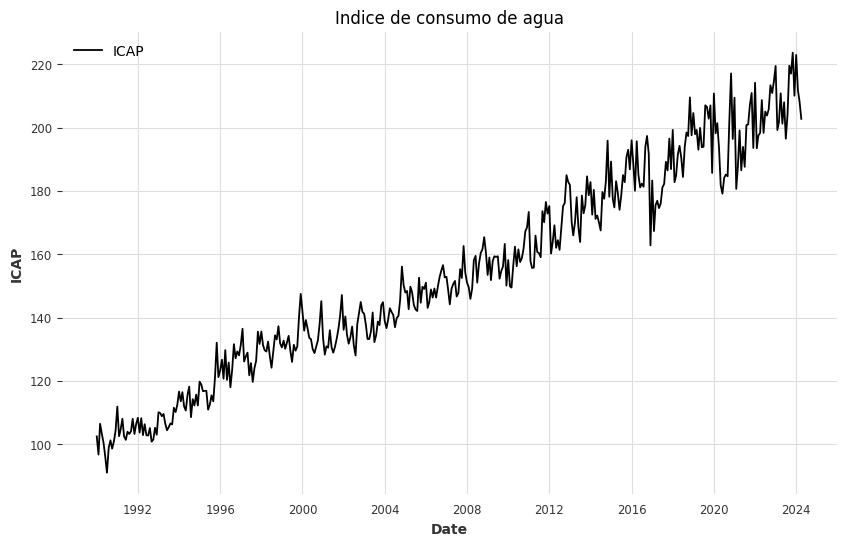

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(df['fecha'], df['icap'], label='ICAP')
plt.title('Indice de consumo de agua')
plt.xlabel('Date')
plt.ylabel('ICAP')
plt.legend()
plt.show()

Si aplicamos una transformación a los datos, cuando se hace la predicción se debe aplicar el inverso para recuperar los datos originales, es decir:

$$Z_t=log(Y_t)\to \widehat Z_t= log(\widehat Y_t)$$

$$\exp(\widehat Z_t)=\widehat Y_t$$



In [6]:
df['log_icap'] = np.log(df['icap'].replace(0, np.nan).dropna())

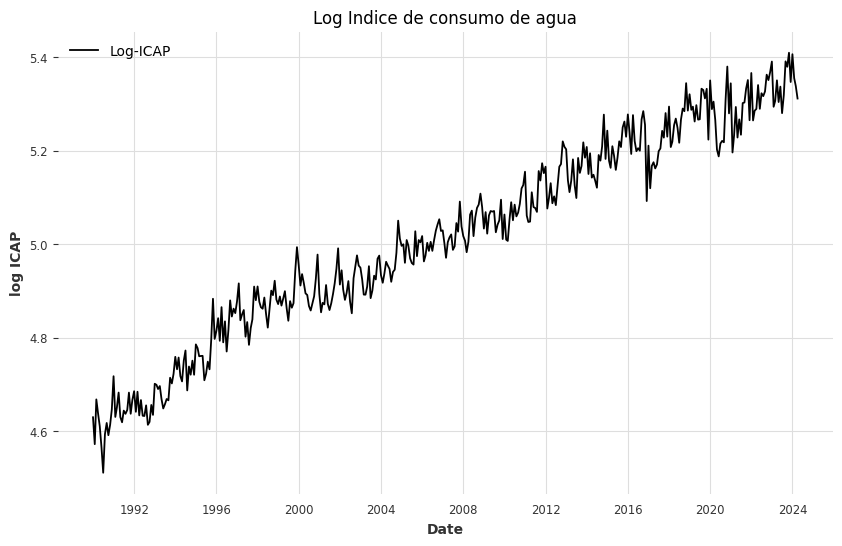

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(df['fecha'], df['log_icap'], label='Log-ICAP')
plt.title('Log Indice de consumo de agua')
plt.xlabel('Date')
plt.ylabel('log ICAP')
plt.legend()
plt.show()

In [7]:
# Ajusta el modelo SARIMA utilizando auto_arima
auto_model = pm.auto_arima(df['log_icap'],
                           seasonal=True, # Indica que se considerarán componentes estacionales en el modelo (SARIMA)
                           m = 12, # Periodo estacional. 12 implica que los patrones se repiten cada 12 unidades (por ejemplo, mensual).
                           stepwise=False, #Si es False, el algoritmo realiza una búsqueda exhaustiva de parámetros. Más preciso pero más lento.
                           suppress_warnings=True, # Suprime advertencias durante el ajuste de modelos (por ejemplo, sobre invertibilidad o estacionariedad).
                           error_action="ignore", # Ignora los errores durante la búsqueda de modelos.
                           max_order=None, # No limita la suma de p + q + P + Q. Si se fijara a un valor, se restringiría la complejidad del modelo.
                           trace=True) # Muestra por consola el progreso de los modelos que se prueban (útil para ver el proceso).

# Obtén el AIC del modelo ajustado
aic_value_auto = auto_model.aic()

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-1421.794, Time=0.27 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-1457.511, Time=0.42 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=-1490.831, Time=2.13 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-1480.877, Time=0.36 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-1537.111, Time=0.90 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=-1536.011, Time=3.24 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=-1518.201, Time=1.12 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=-1536.109, Time=2.57 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=-1533.715, Time=2.56 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-1513.449, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-1560.083, Time=0.61 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=-1605.001, Time=1.91 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-1596.115, Time=0.58 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=-1676.777, Time=1.14 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=-1669

autorarima recomienda 
SARIMA(3,1,1)(1,0,2)[12]


In [9]:
print('AIC autoarima: ', aic_value_auto.round(2))

AIC autoarima:  -1677.12


In [10]:
log_icap_ts = TimeSeries.from_dataframe(df.dropna(subset=['log_icap']), 'fecha', 'log_icap', 
                                        fill_missing_dates=True, freq='MS')
# Diferenciando la serie logarítmica
log_icap_diff = log_icap_ts.diff()

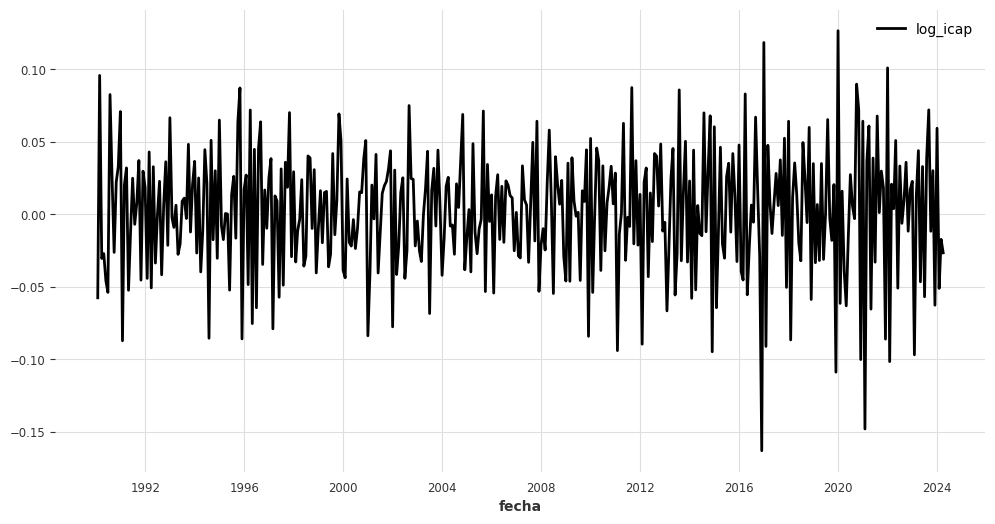

In [11]:
plt.figure(figsize=(12, 6))
log_icap_diff.plot()
plt.show()

In [ ]:
#log_icap_diff_df = log_icap_diff.pd_dataframe()

log_icap_diff_np = log_icap_diff.values().squeeze()# squeeze elimina dimensiones que no son necesarias de un DF o serie
log_icap_diff_df = pd.DataFrame(log_icap_diff_np)

# Imputar los valores NaN con el promedio de la columna
log_icap_diff_df_imputed = log_icap_diff_df.fillna(log_icap_diff_df.mean())

# Convertir de nuevo a un objeto TimeSeries
log_icap_diff_imputed = TimeSeries.from_dataframe(log_icap_diff_df, freq='MS')

Test de Dicker-Fuller

$H_0:\phi=1$, existe raíz unitaria en la serie (no es estacionaria)

$H_1:\phi<1$, no existe raíz unitaria en la serie (es estacionaria)

In [14]:
# Aplicar la prueba de Dickey-Fuller Aumentada
result = adfuller(log_icap_diff_df_imputed.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -6.981769
p-value: 0.000000


SARIMAX(p, d, q) (P, D, Q)[m]

p: parámetro autorregresivo

d: parámetro integrada

q: parámetro media movil

P: parámetro autorregresivo componente estacional

D: parámetro integrada componente estacional

Q: parámetro media movil componente estacional

m: periodicidad estacional


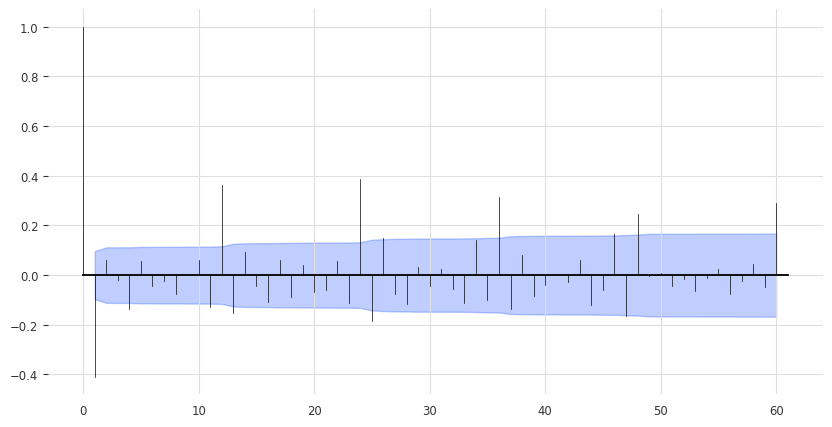

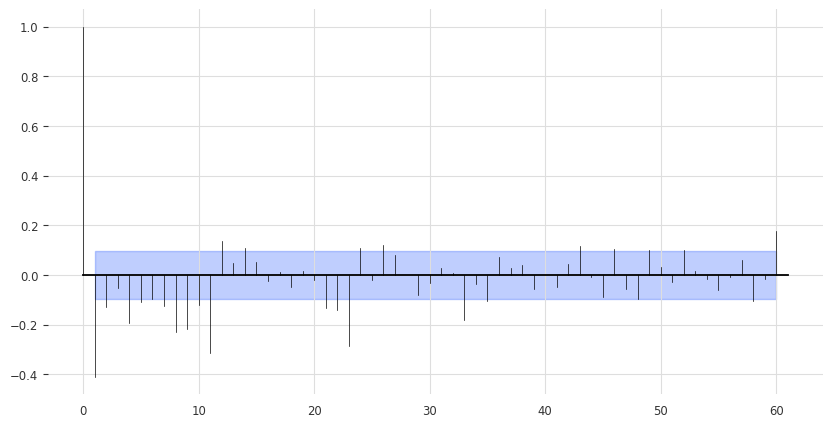

In [26]:
# Graficar ACF
plot_acf(log_icap_diff_imputed, max_lag = 60)

# Graficar PACF
plot_pacf(log_icap_diff_imputed, max_lag = 60)

In [28]:
# Suponiendo que time_series_data es tu serie temporal
y = df['log_icap']
# Parámetros SARIMA
# Parámetros no estacionales (p, d, q)
p, d, q = 4, 1, 1 # Reemplaza con tus valores

# Parámetros estacionales (P, D, Q, m)
P, D, Q, m = 1, 0, 2, 12 # Reemplaza con tus valores (m es la periodicidad estacional)

# Ajuste del modelo SARIMA
modelo_sarima = sm.tsa.SARIMAX(y,
                               order=(p, d, q),
                               seasonal_order=(P, D, Q, m),
                               enforce_stationarity=False,
                               enforce_invertibility=False,
                               trend = 'n')

# Ajuste del modelo
resultado_sarima = modelo_sarima.fit()

# Mostrar el resumen del modelo
print(resultado_sarima.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                log_icap   No. Observations:                  412
Model:             SARIMAX(4, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood                 793.749
Date:                                 Wed, 09 Jul 2025   AIC                          -1569.498
Time:                                         20:46:01   BIC                          -1533.919
Sample:                                              0   HQIC                         -1555.387
                                                 - 412                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1511      0.175     -0.864      0.387      -0.494       0